In [2]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
#from sklearn.externals.joblib import Parallel, delayed, effective_n_jobs
from sklearn.isotonic import IsotonicRegression

def NMDSfunc(dissimilarities, n_dimensions=2, max_iter=300, verbose=False, eps=1e-3, random_state=None):
    '''
    dissimilarities: matrix
    eps: used for convergence
    '''
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)
    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    #Random initial configuration
    X = random_state.rand(n_samples * n_dimensions)
    X = X.reshape((n_samples, n_dimensions))

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)
        dis_flat = dis.ravel()
        dis_flat_w = dis_flat[sim_flat != 0]

        # Finf disparities using monotonic regression
        disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
        disparities = dis_flat.copy()
        disparities[sim_flat != 0] = disparities_flat
        disparities = disparities.reshape((n_samples, n_samples))
        disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) / (disparities ** 2).sum())
        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose:
            print('iteration: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('convergence: breaking at iteration %d with stress %s' % (it,stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def NMDS(dissimilarities, n_dimensions=2, n_init=4,
            max_iter=300, verbose=False, eps=1e-3, random_state=None):
    """
    """
    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    best_pos, best_stress = None, None
    for it in range(n_init):
        pos, stress, n_iter_ = NMDSfunc(dissimilarities, n_dimensions=n_dimensions, max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state)
        print(pos)
        print(stress)
        if best_stress is None or stress < best_stress:
            best_stress = stress
            best_pos = pos.copy()
            best_iter = n_iter_
            
    return best_pos, best_stress, best_iter


class MDS():
    def __init__(self, n_dimensions=2,  n_init=4,
                 max_iter=300, verbose=False, eps=1e-3,
                 random_state=None):
        self.n_dimensions = n_dimensions
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, X, y=None):
      
        #self.fit_transform(X)
        X = check_array(X)
        self.dissimilarity_matrix_ = X
        
        self.embedding, self.stress, self.n_iter = NMDS(self.dissimilarity_matrix_,
            n_dimensions=self.n_dimensions, n_init=self.n_init,
            max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state)
        
        return self

In [3]:
sim = np.array([[0, 5, 3, 4],
                [5, 0, 2, 2],
                [3, 2, 0, 1],
                [4, 2, 1, 0]])
mds_clf = MDS()
a = mds_clf.fit(sim)

[[ 0.09063527  0.05724792]
 [-0.09139582  0.3857177 ]
 [ 0.41445201 -0.24625014]
 [-0.43543306 -0.28412286]]
0.108851030073
[[-0.30283255 -0.60493596]
 [ 0.29134773  0.03754325]
 [ 0.11285247  0.17434456]
 [-0.10912067  0.40002501]]
0.0311131309619
[[-0.57217303 -0.10976503]
 [ 0.12498458  0.33911023]
 [-0.04617869 -0.16876752]
 [ 0.50003692 -0.07664756]]
0.0166176028636
[[ 0.17333506  0.36699569]
 [ 0.34821493 -0.08790215]
 [-0.4502952   0.2025554 ]
 [-0.09816066 -0.44026761]]
0.0567133315082


In [4]:
a.stress

0.016617602863599389

In [5]:
a.embedding

array([[-0.57217303, -0.10976503],
       [ 0.12498458,  0.33911023],
       [-0.04617869, -0.16876752],
       [ 0.50003692, -0.07664756]])

In [6]:
sim2 = np.array([[0, 1, 4, 5, 3, 4, 2, 8, 8, 5, 7, 1],
                [1, 0, 3, 8, 2, 6, 2, 7, 8, 8, 7, 2],
                [4, 3, 0, 7, 2, 3, 3, 7, 8, 6, 4, 3],
                [5, 8, 7, 0, 8, 9, 3, 8, 2, 2, 9, 5],
                [3, 2, 2, 8, 0, 6, 4, 8, 9, 6, 4, 2],
                [4, 6, 3, 9, 6, 0, 1, 3, 9, 8, 5, 3],
                [2, 2, 3, 3, 4, 1, 0, 4, 3, 6, 7, 1],
                [8, 7, 7, 8, 8, 3, 4, 0, 9, 6, 9, 5],
                [8, 8, 8, 2, 9, 9, 3, 9, 0, 4, 9, 9],
                [5, 8, 6, 2, 6, 8, 6, 6, 4, 0, 4, 3],
                [7, 7, 4, 9, 4, 5, 7, 9, 9, 4, 0, 6],
                [1, 2, 3, 5, 2, 3, 1, 5, 9, 3, 6, 0]])
mds_2 = MDS(n_dimensions=4)
b = mds_2.fit(sim2)


[[-0.23437619  0.00683076  0.37821733 -0.11902117]
 [-0.28142423  0.2119778  -0.056523    0.08255906]
 [ 0.24217945 -0.41551114 -0.01959757 -0.15673027]
 [ 0.23741541 -0.19225922 -0.2166393   0.28953588]
 [ 0.0395835  -0.20051023  0.21257259  0.26619214]
 [-0.34685523  0.09508502 -0.07265254 -0.3440715 ]
 [ 0.40169097 -0.04708386 -0.15207507 -0.1377397 ]
 [ 0.03116722  0.10274691 -0.37445101 -0.18698828]
 [ 0.13011546  0.45243896  0.19949129 -0.00672948]
 [-0.3268542  -0.30860049  0.02339799  0.00966566]
 [ 0.19051665  0.06465868  0.29489925 -0.13013939]
 [-0.12595212  0.2961473  -0.28631145  0.5635662 ]]
0.899934285263
[[-0.1930732   0.00513323 -0.15499477  0.37037713]
 [ 0.08366458  0.255595   -0.21026823 -0.31780792]
 [-0.12924396  0.32535377  0.06873624  0.10686629]
 [ 0.107743    0.38907374 -0.05052672  0.10620623]
 [-0.16935586 -0.19221569 -0.29739836  0.18618287]
 [ 0.19674524 -0.13769283 -0.35195159  0.08249283]
 [ 0.41530039 -0.02533388  0.28937938 -0.14186352]
 [ 0.29640212 -

In [12]:
b.stress

0.29176790463819546

In [7]:
output = []
for i in range(1,15):
    model = MDS(n_dimensions=i)
    b = model.fit(sim2)
    output.append(b)


[[ 0.07051988]
 [-0.09611105]
 [-0.05717764]
 [ 0.37649061]
 [-0.28047707]
 [-0.1816042 ]
 [ 0.03240495]
 [-0.76488846]
 [-0.61189235]
 [ 0.94338005]
 [ 0.61146456]
 [ 0.23139692]]
4.12713253474
[[-0.26664806]
 [ 0.61266276]
 [-0.23436644]
 [-0.14794148]
 [ 0.57500517]
 [-0.30444473]
 [ 0.51088077]
 [-0.58666999]
 [ 0.21092473]
 [ 0.37531964]
 [ 0.00275653]
 [-1.04643642]]
5.28558367111
[[ 0.05794702]
 [-0.0063759 ]
 [-0.34717922]
 [ 0.67469263]
 [-0.32502325]
 [ 0.33147259]
 [ 0.4087522 ]
 [ 0.16285476]
 [-0.17861268]
 [-0.52922834]
 [-0.83435407]
 [ 0.73642482]]
4.39844623741
[[ 0.14166032]
 [-0.23616461]
 [-0.05476227]
 [ 0.19429877]
 [-0.44723716]
 [-0.14390714]
 [-0.00706679]
 [-0.26805029]
 [-0.61888398]
 [ 0.66390135]
 [ 0.97511808]
 [ 0.61008893]]
4.49226718296
[[ 0.00474693  0.02096425]
 [-0.119083    0.05300705]
 [-0.11875875 -0.21493079]
 [-0.25873438  0.04770255]
 [ 0.44077013 -0.43826835]
 [-0.43167766 -0.21845383]
 [ 0.18631307  0.19298257]
 [ 0.23034762 -0.14283768]
 [-0

[[-0.22593633  0.15715346  0.1019352   0.15932284 -0.00323207  0.24338784]
 [ 0.30940181 -0.12486638  0.07384901  0.22879153  0.03260085  0.01931761]
 [ 0.08495342 -0.16323531 -0.03576589 -0.01682947 -0.25016258  0.21226777]
 [-0.32885594  0.13046673 -0.2484803   0.08076696 -0.21557242 -0.18999554]
 [-0.1651958  -0.06550468 -0.2286307   0.10969353  0.23233562  0.1859744 ]
 [ 0.05050494 -0.32412441  0.08561079 -0.36542827  0.06902209 -0.13880911]
 [ 0.03535462  0.27318963  0.04640963  0.14536467  0.10369306 -0.30508852]
 [-0.18621289 -0.33283032  0.10664313  0.17564683  0.00294867 -0.17666737]
 [ 0.20246297  0.33560591  0.20638488  0.12901587 -0.39580505  0.14037373]
 [-0.16865813  0.12536658  0.16647601 -0.28306846 -0.04448651 -0.01215589]
 [ 0.21955404  0.03788966  0.09300858 -0.18838477  0.45343222  0.17530093]
 [ 0.20226657 -0.03038897 -0.36650564 -0.17296841  0.01960948 -0.154968  ]]
0.216616043785
[[-0.09300115  0.15154455 -0.01481101 -0.27330591 -0.03063354 -0.33678913]
 [-0.3307

[[  2.41241535e-01  -2.04329976e-01   2.17627810e-02  -6.33140938e-02
    1.97368903e-01   5.54848182e-02  -1.38451288e-01   1.56371765e-01
   -1.26623454e-01  -7.60507009e-02]
 [  7.77892285e-02   2.83267883e-02  -2.89126536e-01   1.70492632e-01
   -1.55748893e-01   1.57317964e-01  -8.68499122e-02  -3.86342500e-02
   -1.76506999e-01   1.42536767e-01]
 [ -2.70007067e-02   1.57857655e-01  -2.23642435e-01  -9.90195084e-02
    1.89399151e-01  -1.16618571e-01   1.40593036e-03   2.64266404e-01
    7.71474771e-02   5.55123543e-02]
 [ -1.29612611e-01  -2.98656429e-01   6.27795105e-02  -1.68901901e-01
    4.83531814e-02   4.54113509e-02  -2.35757252e-01  -1.01974283e-01
   -2.82735325e-02   4.60495353e-02]
 [  9.99230161e-02  -1.23257366e-01  -1.69497003e-01   1.57111553e-01
   -1.09166985e-01   8.51657134e-03  -8.67994623e-02  -1.37548063e-01
    2.09464420e-01  -2.21911763e-01]
 [ -2.22907461e-01   1.88963843e-01   1.85012556e-01  -3.00900544e-01
   -1.23752699e-01  -1.30207031e-01   9.28482

[[-0.04270412 -0.20952476 -0.07147964  0.07076627  0.30107427  0.00532569
   0.07829066 -0.07581722  0.06600404  0.20320867  0.04325363  0.06133339
  -0.08562965 -0.09692436]
 [ 0.08078687  0.2963541   0.14149302 -0.02194727  0.05854527  0.25437995
  -0.07988     0.15863171 -0.06024452 -0.04836183 -0.00838039  0.02592689
   0.04779333  0.13981506]
 [ 0.22775244 -0.06459811  0.14517212  0.01011801 -0.10826361 -0.05964655
   0.15193096  0.16740307 -0.22298936  0.07226374  0.02423644  0.11373477
   0.04483581 -0.09272054]
 [-0.0168477   0.12761602  0.10556336  0.15132131  0.18967176 -0.09333285
   0.05123801 -0.10444245 -0.12420967 -0.01362786  0.18363461 -0.16781083
   0.05315141 -0.11461466]
 [ 0.1874615  -0.08527143 -0.18281425  0.06893199 -0.05741634  0.2400529
  -0.00672149  0.0421117   0.28528449 -0.1078611  -0.09033918  0.02703501
   0.01518252  0.02483176]
 [-0.19499028 -0.14005259  0.13915219  0.12459177  0.00204893 -0.11861935
  -0.07707425  0.04218446  0.17046361 -0.10308857 -0

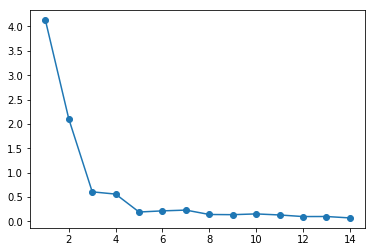

In [10]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
plt.show()